In [12]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tqdm as tqdm

In [13]:
from tqdm import tqdm
import os
import numpy as np
import cv2

def load_data(image_path, mask_path, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Data"):
        new_image_path = os.path.join(image_path, image_file)
        new_mask_path = os.path.join(mask_path, mask_file)

        image = cv2.imread(new_image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Warning: Could not load image {image_file}")
            continue
        if mask is None:
            print(f"Warning: Could not load mask {mask_file}")
            continue

        image = cv2.resize(image, img_size) / 255.0 
        mask = cv2.resize(mask, img_size) / 255.0
        kernel = np.ones((3, 3), np.uint8)

        eroded_mask = cv2.erode(mask, kernel, iterations=1)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        
        final_mask = dilated_mask # Or eroded_mask, or the original mask
        mask = np.expand_dims(final_mask, axis=-1)

        images.append(image)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)


In [14]:
inputs = layers.Input((256, 256, 3))

c1 = layers.Conv2D(16 , (3,3) , activation='relu' , kernel_initializer='he_normal' , padding='same')(inputs)
c1 = layers.Dropout(0.1)(c1)
c1 = layers.Conv2D(16 , (3,3) , activation='relu' , kernel_initializer='he_normal' , padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.Dropout(0.1)(c2)
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)
 
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)
 
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = layers.Dropout(0.1)(c8)
c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = layers.Dropout(0.1)(c9)
c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
!ls /kaggle/input
!ls /kaggle/input/new-crack
!ls /kaggle/input/data


data
ls: cannot access '/kaggle/input/new-crack': No such file or directory
data-crack  new_mask_folder


In [15]:
image_path = '/kaggle/input/data/data-crack'
mask_path = '/kaggle/input/data/new_mask_folder'

im, ma = load_data(image_path, mask_path)
print("DONE👍")

Loading Data: 100%|██████████| 1130/1130 [01:13<00:00, 15.33it/s]


DONE👍


In [16]:
# X_train, X_temp, Y_train, Y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train, X_temp, Y_train, Y_temp = train_test_split(im, ma, test_size=0.2, random_state=42)

X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 904, Validation: 113, Test: 113


In [18]:
# checkpoints = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
# ]

# history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=25, callbacks=callbacks, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=20,
    verbose=1
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9849 - loss: 0.0436 - val_accuracy: 0.9862 - val_loss: 0.0392
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9843 - loss: 0.0446 - val_accuracy: 0.9866 - val_loss: 0.0365
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9852 - loss: 0.0413 - val_accuracy: 0.9865 - val_loss: 0.0376
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9856 - loss: 0.0395 - val_accuracy: 0.9875 - val_loss: 0.0346
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9865 - loss: 0.0375 - val_accuracy: 0.9873 - val_loss: 0.0350
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9856 - loss: 0.0399 - val_accuracy: 0.9876 - val_loss: 0.0338
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9871 - loss: 0.0360 - val_accuracy: 0.9876 - val_loss: 0.0332
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9859 - loss: 0.0387 - val_accuracy: 0.9879 - v

In [19]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.35).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 926ms/step


In [20]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

ious = [iou_score(Y_test[i], Y_pred[i]) for i in range(len(Y_test))]
mean_iou = np.mean(ious)

print(f"Mean IoU Score: {mean_iou:.4f}")


Mean IoU Score: 0.6322


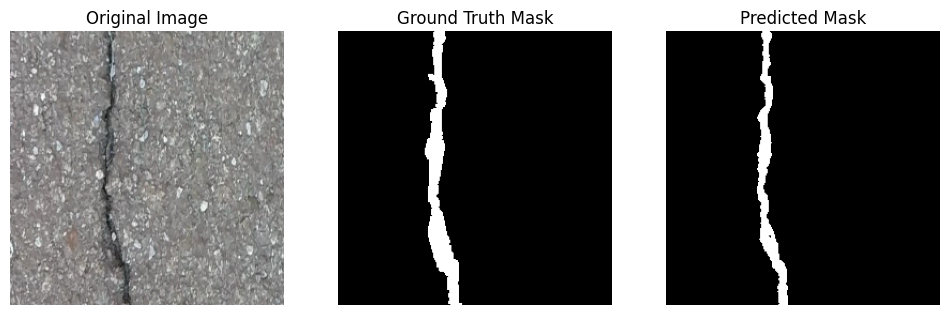

Sample IoU Score: 0.6824


In [21]:
import random

random_index = random.randint(0, len(X_test) - 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[random_index])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Y_test[random_index], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(Y_pred[random_index], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

iou_score_sample = iou_score(Y_test[random_index], Y_pred[random_index])
print(f"Sample IoU Score: {iou_score_sample:.4f}")